# **TensorFlow Classification Notebook**

The notebook was created for the RSNA-MICCAI Brain Tumor Radiogenomic Classification competition which was hosted in the first half of 2021. The goal of the competition was to predict the genetic subtype of glioblastoma using MRI (magnetic resonance imaging) scans to train and test a model to detect the presence of MGMT promoter methylation.

Currently, the model created in this notebook archives a predictive value of just 60%. This is most likely due to us only using one of the imaging groups provided. The imaging group used is FLAIR.

Fluid attenuated inversion recovery (FLAIR) is a special inversion recovery sequence with a long inversion time. This removes the signal from the cerebrospinal fluid in the resulting images. Brain tissue on FLAIR images appears similar to T2 weighted images with grey matter brighter than white matter but CSF is dark instead of bright.

Furthermore, for the construction of this model, a transfer learning method was used and the model is based on EfficientNetB0.

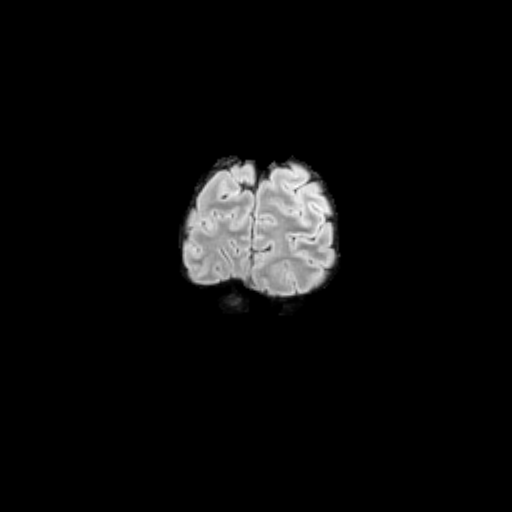

In [ ]:
import os
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf

from sklearn.model_selection import train_test_split

In [ ]:
df_train = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

In [ ]:
random_path = "../input/rsna-miccai-png/train/00003/FLAIR"
frames = [Image.open(image) for image in glob.glob(f"{random_path}/*.png")]

plt.figure(figsize=(20,10),facecolor=(0,0,0))
plt.axis("off")

for img_indx in range(len(frames[:32])):
    ax = plt.subplot(4,8,img_indx+1)
    ax.imshow(frames[img_indx], cmap="gray")
    ax.axis("off")
    ax.set_title(str(img_indx+1),color='r',y=-0.01)

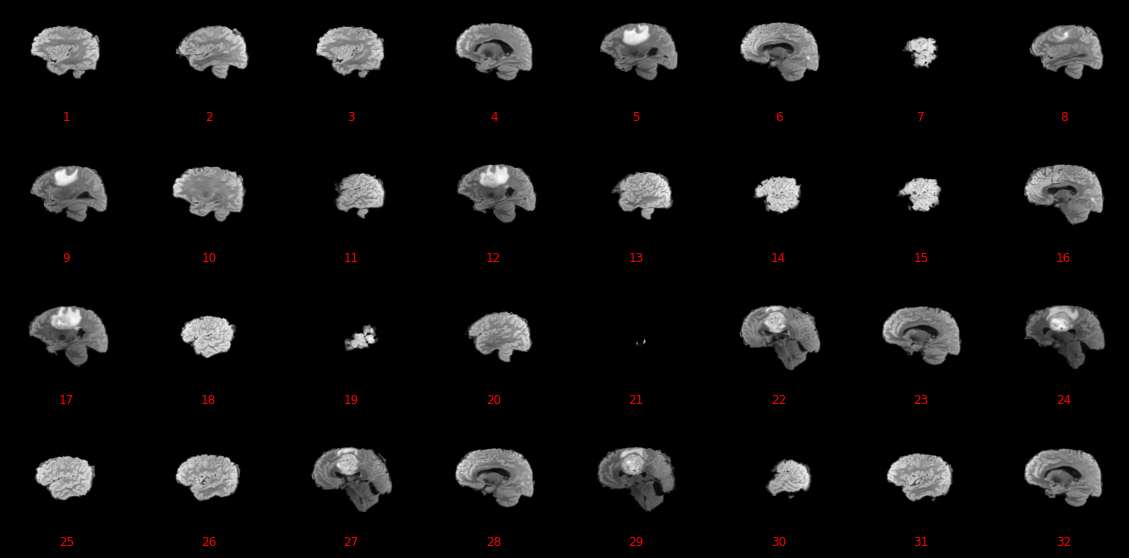

In [ ]:
NUMBER_OF_FRAMES = 10
BATCH_SIZE = 8
EPOCHS = 100
IMGS_SIZE = 224
LSTM_UNITS = 256

In [ ]:
def get_paths(df, core_path: str):
    
    path_list = []
    
    for i in df["BraTS21ID"]:
        if len(str(i)) < 5:
            part = "0" * (5-len(str(i))) + str(i)
            full_path = os.path.join(core_path, part, "FLAIR")
            path_list.append(full_path)
            
        else:
            path_list.append(os.path.join(core_path, i, "FLAIR"))
    
    return path_list

In [ ]:
train_path = "../input/rsna-miccai-png/train"
df_train["path"] = get_paths(df_train, train_path)
df_train = df_train.loc[df_train.BraTS21ID!=109]
df_train = df_train.loc[df_train.BraTS21ID!=709]
df_train = df_train.reset_index(drop=True)
df_train.head()

In [ ]:
def img_loader(path):
    
    img = tf.io.read_file(path)
    img = decode_image(img)
    img = tf.image.resize(img, (IMGS_SIZE,IMGS_SIZE))
    
    return img

def decode_image(image):
    
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    return image

In [ ]:
def frame_selection(path):
    
    r = re.compile('([0-9]+).png')
    
    user_img_paths = []
    img_number = []
    
    paths = glob.glob(path.decode('utf8') + "/*.png")
    
    for path in paths:
        
        img_number.append(int(r.search(path).group(1)))
            
    n_img_path = np.array(paths)
    n_img_num = np.array(img_number)
        
    inds = n_img_num.argsort()
    sorted_user_list = n_img_path[inds].tolist()
    
    start = tf.random.uniform((1,), maxval=len(sorted_user_list)-NUMBER_OF_FRAMES, dtype=tf.int32)
    
    
    ### Place number of frames in brackets to create a tensor
    paths = tf.slice(sorted_user_list, start, [NUMBER_OF_FRAMES])
                
    img = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn=img_loader, elems=paths, fn_output_signature=tf.float32))
        
    return img

In [ ]:
def load_frame(df_dict):
    
    path_names = df_dict["path"]
    paths = tf.numpy_function(frame_selection, [path_names], tf.float32)
    
    # Parse label
    label = df_dict["MGMT_value"]
    label = tf.cast(label, tf.float32)
    
    return paths, label

In [ ]:
train_df, valid_df = train_test_split(df_train, test_size=0.1, stratify=df_train.MGMT_value.values)
print(f'Size of train_df: {len(train_df)}; valid_df: {len(valid_df)}')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

trainloader = tf.data.Dataset.from_tensor_slices(dict(train_df))
validloader = tf.data.Dataset.from_tensor_slices(dict(valid_df))


trainloader= (
    trainloader
    .shuffle(1024)
    .map(load_frame, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

validloader = (
    validloader
    .map(load_frame, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [ ]:
def image_plotting(loader):
    
    
    ax, fig = plt.subplots(2,5,figsize=(10,2))
    
    for i in range(NUMBER_OF_FRAMES):
        
        i=+1
        frames, lab = next(iter(loader))
        frames = frames[0,0,:,:]
    
        plt.subplot(2,5, i)
        
        plt.imshow(frames)

In [ ]:
ax, fig = plt.subplots(figsize=(15,2))

for i in range(NUMBER_OF_FRAMES):
    
    i += 1
    frames, labels = next(iter(trainloader))
    frames = frames[0,0,:,:]
    
    plt.subplot(2,5, i)
    plt.imshow(frames)

In [ ]:
### Functions for training ###

def model_generation():
    
    tf.keras.backend.clear_session()
    transfer_learning = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet")
    transfer_learning.trainable = True
    inputs = tf.keras.Input(shape=(IMGS_SIZE, IMGS_SIZE, 1))
    
    
    x = tf.keras.layers.Conv2D(3, kernel_size=(3,3), padding="same", activation="relu")(inputs)
    x = transfer_learning(x, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    return tf.keras.Model(inputs, x)

model = model_generation()

### Temportal model generation ###

def temp_model_generation():
    
    tf.keras.backend.clear_session() 
    inputs = tf.keras.Input(shape = (NUMBER_OF_FRAMES, IMGS_SIZE, IMGS_SIZE, 1))
    
    base_model = model_generation()
    
    #Wrapper that allows the application on each temporal layer
    time_wrap = tf.keras.layers.TimeDistributed(base_model)(inputs)
    lstm = tf.keras.layers.LSTM(LSTM_UNITS, return_sequences = True)(time_wrap)
    outro = tf.keras.layers.Dense(1, activation="sigmoid")(lstm)
    
    return tf.keras.Model(inputs, outro)


tf.keras.backend.clear_session() 
final_model = temp_model_generation()
final_model.summary()

In [ ]:
### Model Callbacks ####

earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, verbose=0, mode="min",
    restore_best_weights=True
)

In [ ]:
tf.keras.backend.clear_session() 
final_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy', metrics=['acc'])



history = final_model.fit(trainloader,
                         epochs = EPOCHS,
                         validation_data = validloader,
                         callbacks=[earlystopper,model_save])

In [ ]:
loss, acc = final_model.evaluate(validloader)

References:
https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification
https://radiopaedia.org/articles/fluid-attenuated-inversion-recovery
https://www.kaggle.com/ayuraj/brain-tumor-eda-and-interactive-viz-with-w-b
https://www.kaggle.com/kavehshahhosseini/rsna-brain-tumor-tensorflow-tpu-tfrecords-train?rvi=1
https://www.kaggle.com/ammarnassanalhajali/brain-tumor-3d-inference
https://www.med.upenn.edu/cbica/brats2021/